#U-Net을 활용한 위성 사진 Image Segmentation



In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import albumentations

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose, OneOf
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = '/content/drive/My Drive/DataSet/Training/source'
val_path = '/content/drive/My Drive/DataSet/Validation/source'

# Data preprocessing

In [ ]:
class SatileDataSet(Dataset):
  def __init__(self, path, transform, mode = None):
    super().__init__()
    self.path = path
    self.labels_path = path.replace('source', 'label')
    self.transform = transform

    self.labels = []
    self.imgs = []

    if mode is not None:
      for source_name in os.listdir(self.path)[:2000]:
        if source_name in os.listdir(self.labels_path):
          self.labels.append(os.path.join(self.labels_path, source_name))
          self.imgs.append(os.path.join(path, source_name))
    else :
      for source_name in os.listdir(self.path):
        if source_name in os.listdir(self.labels_path):
          self.labels.append(os.path.join(self.labels_path, source_name))
          self.imgs.append(os.path.join(path, source_name))
  def __getitem__(self, idx):

    image_path = self.imgs[idx]
    label_path = self.labels[idx]

    image = Image.open(image_path).convert('RGB')
    label = Image.open(label_path).convert('L')


    image = np.array(image, dtype=np.float64)
    label = np.array(label, dtype=np.float64)

    image /= 255.
    label /= 10.
    label -= 1

    if image.ndim == 2:
      image = np.expand_dims(image, -1)

    if self.transform is not None:
      augmented = self.transform(image = image, mask = label)
      image, label = augmented['image'], augmented['mask']
      image = torch.from_numpy(image).permute(2,0,1)
      label = torch.from_numpy(label)
      #label = torch.from_numpy(label).permute(2,0,1)
      image = (image - 0.5) / 0.5


    return image, label

  def __len__(self):
    assert len(self.imgs) == len(self.labels)
    return len(self.imgs)

In [ ]:
def make_transform(mode):
  if mode == 'train':
      train_transform = Compose([
          albumentations.Resize(width = 512, height = 512),
          albumentations.ElasticTransform(),
          OneOf([albumentations.HorizontalFlip(),
            albumentations.RandomRotate90(),
            albumentations.VerticalFlip()]),
          ])
      return train_transform
  else :
    test_transform = Compose([
      albumentations.Resize(width = 512, height = 512),
    ])
    return test_transform

In [ ]:
train_transform = make_transform('train')
test_transform = make_transform('test')

train = SatileDataSet(train_path, transform=train_transform, mode='train')
val = SatileDataSet(val_path, transform = test_transform)


In [ ]:
batch_size = 4

train_loader = DataLoader(train, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size = batch_size, shuffle=False)

# U-Net Model

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels, mid_channels = None):
    super().__init__()
    if not mid_channels:
      mid_channels = out_channels
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

  def forward(self, x):
    return self.double_conv(x)

In [ ]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [ ]:
class Up(nn.Module):

  def __init__(self, in_channels, out_channels, bilinear=True):
    super().__init__()

    if bilinear:
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
    else:
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)

    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]

    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                    diffY // 2, diffY - diffY // 2])

    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)


In [ ]:
class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)

In [ ]:
class UNet(nn.Module):
  def __init__(self, n_channels, n_classes, bilinear=True):
    super(UNet, self).__init__()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.bilinear = bilinear

    self.inc = DoubleConv(n_channels, 64)
    self.down1 = Down(64, 128)
    self.down2 = Down(128, 256)
    self.down3 = Down(256, 512)
    factor = 2 if bilinear else 1
    self.down4 = Down(512, 1024 // factor)
    self.up1 = Up(1024, 512 // factor, bilinear)
    self.up2 = Up(512, 256 // factor, bilinear)
    self.up3 = Up(256, 128 // factor, bilinear)
    self.up4 = Up(128, 64, bilinear)
    self.outc = OutConv(64, n_classes)

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.outc(x)
    return logits

# Hyperparameter

In [ ]:
epochs = 100
learning_rate = 0.001

device = 'cuda'
model = UNet(3, 10, False)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, factor= 0.1)
criterion = nn.CrossEntropyLoss()

# Training

In [ ]:
def training(model, train_loader, epochs, criterion, optimizer, scheduler, save_path, val_loader = None, device = 'cuda'):


  for epoch in range(epochs):
    model.train()
    train_loss = 0

    for i, (image, label) in enumerate(tqdm(train_loader, total=len(train_loader))):
      image = image.to(device = device, dtype = torch.float32)
      label = label.to(device = device, dtype = torch.int64)
      #label = torch.nn.functional.one_hot(label, num_classes = 10)
      model = model.to(device)
      pred = model(image)
      image = image.permute((0,2,3,1))
      loss = criterion(pred, label)
      train_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()
      nn.utils.clip_grad_value_(model.parameters(), 0.1)
      optimizer.step()

      if val_loader is not None:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
          for j, (image, label) in enumerate(val_loader):
            image = image.to(device = device, dtype = torch.float32)
            label = label.to(device = device, dtype = torch.int64)
            #label = torch.nn.functional.one_hot(label, num_classes = 10)
            image = image.permute((0,2,3,1))

            pred = model(image)
            loss = criterion(pred, label)
            val_loss += loss.item()

      else:
        val_loss = 0.0
        j = 0

    schedule_standard = train_loss / (i+1)
    scheduler.step(schedule_standard)
    print("epoch: {}/{}  | trn loss: {:.4f} | val loss: {:.4f}".format(
            epoch+1, epochs, train_loss /(i+1), val_loss /(j+1)))

    #checkpoint = {'loss':train_loss/(i+1),
    #              'state_dict': model.state_dict(),
    #              'optimizer': optimizer.state_dict()}
    #torch.save(checkpoint, save_path+'{}_epoch.pth'.format(epoch))
    torch.save(model.state_dict(), save_path+'{}_epoch.pth'.format(epoch))

In [ ]:
training(model, train_loader, epochs, criterion, optimizer, scheduler, '/content/drive/My Drive/UNetResult/')

  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 1/100  | trn loss: 1.0880 | val loss: 0.0000


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 2/100  | trn loss: 0.9274 | val loss: 0.0000


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 3/100  | trn loss: 0.8568 | val loss: 0.0000


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 4/100  | trn loss: 0.7837 | val loss: 0.0000


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 5/100  | trn loss: 0.7393 | val loss: 0.0000


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 6/100  | trn loss: 0.6911 | val loss: 0.0000


  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 7/100  | trn loss: 0.6577 | val loss: 0.0000


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# Evaluate

In [ ]:
def Dice(image, label):
  check_image = torch.argmax(image, dim = -1)
  check_image = torch.nn.functional.one_hot(check_image, num_classes = 10)
  check_image = check_image.view(-1)
  label = torch.nn.functional.one_hot(label, num_classes = 10)
  check_label = label.view(-1)


  intersection = (check_image * check_label).sum()
  dice = (2. * intersection + 1) / (check_image.sum() + check_label.sum() + 1)

  return dice

In [ ]:
def evaluate(model, test_loader, device = 'cuda'):
  model.eval()
  with torch.no_grad():
    total_loss = 0.0
    accuracy = 0.0

    for i, (image, label) in enumerate(tqdm(test_loader, total = len(test_loader))):
      image = image.to(device = device, dtype = torch.float32)
      label = label.to(device = device, dtype = torch.int64)
      #label = torch.nn.functional.one_hot(label, num_classes = 10)

      pred = model(image)
      image = image.permute((0,2,3,1))
      total_loss += F.cross_entropy(pred, label).item()

      accuracy += Dice(image, label)
    print("Total Loss: : {:.4f}  | loss: {:.4f}".format(accuracy /(i+1), total_loss /(i+1)))

In [ ]:
#model = UNet(3, 10, False)
#model.load_state_dict(torch.load('save_path+'200_epoch.pth'))
evaluate(model, val_loader)

  0%|          | 0/125 [00:00<?, ?it/s]

Total Loss: : 0.0249  | loss: 0.6997


# 결과 확인

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


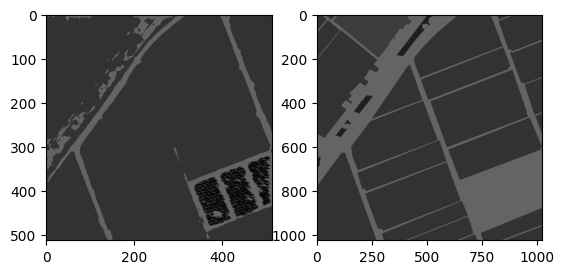

In [ ]:
import cv2

check = '/content/drive/My Drive/DataSet/Training/source/LC_GS_AP25_36805077_084_2019_FGT_1024.tif'
check_label = '/content/drive/My Drive/DataSet/Training/label/LC_GS_AP25_36805077_084_2019_FGT_1024.tif'
image = Image.open(check).convert("RGB")
image = np.array(image, dtype = np.float32)
image = torch.tensor(image)
image /= 255.
image = image.to(device = device, dtype = torch.float32)
image = image.permute((2,0,1))
image = T.Resize((512,512))(image)
image = image.unsqueeze(0)

model.eval()
with torch.no_grad():

  output = model(image)
  output = output.permute((0,2,3,1))
  output = torch.argmax(output, dim = -1, keepdim = True)
  output = (output.repeat(1,1,1,3) + 1) * 10

  import matplotlib.pyplot as plt
  plt.subplot(1,2,1)
  plt.imshow(output.squeeze(0).to('cpu').numpy())
  plt.subplot(1,2,2)
  plt.imshow(np.repeat(np.expand_dims(np.array(Image.open(check_label).convert('L')), axis=-1), 3, axis = -1))